In [2]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions

from Bio.PDB.PDBParser import PDBParser
sys.path.insert(0, '/Users/weilu/Research/opt_server/')
from pyCodeLib import *
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
code = {"GLY" : "G", "ALA" : "A", "LEU" : "L", "ILE" : "I",
        "ARG" : "R", "LYS" : "K", "MET" : "M", "CYS" : "C",
        "TYR" : "Y", "THR" : "T", "PRO" : "P", "SER" : "S",
        "TRP" : "W", "ASP" : "D", "GLU" : "E", "ASN" : "N",
        "GLN" : "Q", "PHE" : "F", "HIS" : "H", "VAL" : "V",
        "M3L" : "K", "MSE" : "M", "CAS" : "C"}
gamma_se_map_1_letter = {   'A': 0,  'R': 1,  'N': 2,  'D': 3,  'C': 4,
                            'Q': 5,  'E': 6,  'G': 7,  'H': 8,  'I': 9,
                            'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14,
                            'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}

In [4]:
p=PDBParser()
structure=p.get_structure("x", "/Users/weilu/Research/server/may_week3_2020/hemoglobin/setups/four_chains/5x2r-openmmawsem.pdb")

In [22]:
from pdbfixer import PDBFixer
pdbFile = "/Users/weilu/Research/server/may_week3_2020/hemoglobin/setups/debug_displacement_of_N/crystal_structure-cleaned.pdb"
fixer = PDBFixer(filename=pdbFile)

In [25]:
fixer.removeHeterogens(keepWater=False)
chains = list(fixer.topology.chains())

In [43]:
pdb_file = "/Users/weilu/Research/server/may_week3_2020/hemoglobin/setups/debug_displacement_of_N/crystal_structure-openmmawsem.pdb"
parser = PDBParser(QUIET=True)
structure=parser.get_structure('X',pdb_file,)
res = list(structure.get_residues())
model = structure[0]
output_file = "/Users/weilu/Research/server/may_week3_2020/hemoglobin/setups/debug_displacement_of_N/crystal_structure-openmmawsem_test.pdb"
use_cis_proline = False

f = open(pdb_file)
all_lines = f.readlines()
f.close()
output = open(output_file, "w")
index = 0
for line in all_lines:
    # print(line)
    splitline = line.split()
    if len(line)>4 and line[0:4] == "ATOM":
        try:
            atom_index=line[6:11].strip()
            atom_type=line[12:16].strip()
            res_type=line[17:20].strip()
            chain=line[21].strip()
            res_index=line[22:26].strip()
            x=line[30:38].strip()
            y=line[38:46].strip()
            z=line[46:54].strip()
            element = line[76:78].strip()
        except ValueError:
            print(line)
            raise
    else:
        continue
    res_index = int(res_index)

    r_im = model[chain][max(res_index-1,1)]
    r_i = model[chain][res_index]
    try:
        r_ip = model[chain][res_index+1]
    except:
        r_ip = model[chain][res_index]  # won't be used
    if use_cis_proline and res_type == "IPR":
        n_coord = -0.2094*r_im['CA'].get_coord()+ 0.6908*r_i['CA'].get_coord() + 0.5190*r_im['O'].get_coord()
        c_coord = 0.2196*r_i['CA'].get_coord()+ 0.2300*r_ip['CA'].get_coord() + 0.5507*r_i['O'].get_coord()
        h_coord = -0.9871*r_im['CA'].get_coord()+ 0.9326*r_i['CA'].get_coord() + 1.0604*r_im['O'].get_coord()
    else:
        n_coord = 0.48318*r_im['CA'].get_coord()+ 0.70328*r_i['CA'].get_coord()- 0.18643 *r_im['O'].get_coord()
        c_coord = 0.44365*r_i['CA'].get_coord()+ 0.23520*r_ip['CA'].get_coord()+ 0.32115 *r_i['O'].get_coord()
        h_coord = 0.84100*r_im['CA'].get_coord()+ 0.89296*r_i['CA'].get_coord()- 0.73389 *r_im['O'].get_coord()

    line_list=list(line)
    index += 1
    line_list[6:11] = "{:5d}".format(index)
    if atom_type == "N":
        line_list[30:38] = '{:.8s}'.format('{:8.3f}'.format(n_coord[0]))
        line_list[38:46] = '{:.8s}'.format('{:8.3f}'.format(n_coord[1]))
        line_list[46:54] = list('{:.8s}'.format('{:8.3f}'.format(n_coord[2])))
    if atom_type == "C":
        line_list[30:38] = '{:.8s}'.format('{:8.3f}'.format(c_coord[0]))
        line_list[38:46] = '{:.8s}'.format('{:8.3f}'.format(c_coord[1]))
        line_list[46:54] = list('{:.8s}'.format('{:8.3f}'.format(c_coord[2])))
    if atom_type == "H":
        line_list[30:38] = '{:.8s}'.format('{:8.3f}'.format(h_coord[0]))
        line_list[38:46] = '{:.8s}'.format('{:8.3f}'.format(h_coord[1]))
        line_list[46:54] = list('{:.8s}'.format('{:8.3f}'.format(h_coord[2])))
    new_line=''.join(line_list)
    output.write(new_line)
index += 1
line_list[6:11] = "{:5d}".format(index)
line_list[0:4] = "TER "
line_list[30:78] = " " * 48
new_line=''.join(line_list)
output.write(new_line)
output.write("END\n")
output.close()

In [37]:
a = structure[0]

In [40]:
res

[<Residue NGP het=  resseq=1 icode= >,
 <Residue NGP het=  resseq=2 icode= >,
 <Residue IPR het=  resseq=3 icode= >,
 <Residue NGP het=  resseq=4 icode= >,
 <Residue NGP het=  resseq=5 icode= >,
 <Residue NGP het=  resseq=6 icode= >,
 <Residue NGP het=  resseq=7 icode= >,
 <Residue NGP het=  resseq=8 icode= >,
 <Residue NGP het=  resseq=9 icode= >,
 <Residue NGP het=  resseq=10 icode= >,
 <Residue NGP het=  resseq=11 icode= >,
 <Residue NGP het=  resseq=12 icode= >,
 <Residue NGP het=  resseq=13 icode= >,
 <Residue IGL het=  resseq=14 icode= >,
 <Residue NGP het=  resseq=15 icode= >,
 <Residue NGP het=  resseq=16 icode= >,
 <Residue IGL het=  resseq=17 icode= >,
 <Residue NGP het=  resseq=18 icode= >,
 <Residue NGP het=  resseq=19 icode= >,
 <Residue NGP het=  resseq=20 icode= >,
 <Residue IGL het=  resseq=21 icode= >,
 <Residue NGP het=  resseq=22 icode= >,
 <Residue NGP het=  resseq=23 icode= >,
 <Residue IGL het=  resseq=24 icode= >,
 <Residue NGP het=  resseq=25 icode= >,
 <Residue

In [39]:
a["C"][1]

<Residue NGP het=  resseq=1 icode= >

In [30]:
all_lines

['ATOM      1  CA  NGP A   1      46.195  15.366  12.692  1.00  0.00           C  \n',
 'ATOM      2  C   NGP A   1      46.509  16.833  13.047  1.00  0.00           C  \n',
 'ATOM      3  O   NGP A   1      47.375  17.463  12.430  1.00  0.00           O  \n',
 'ATOM      4  CB  NGP A   1      47.176  14.803  11.635  1.00  0.00           B  \n',
 'ATOM      5  N   NGP A   2      45.782  17.349  14.054  1.00  0.00           N  \n',
 'ATOM      6  H   NGP A   2      45.086  16.842  14.552  1.00  0.00           H  \n',
 'ATOM      7  CA  NGP A   2      45.919  18.741  14.559  1.00  0.00           C  \n',
 'ATOM      8  C   NGP A   2      47.311  18.936  15.237  1.00  0.00           C  \n',
 'ATOM      9  O   NGP A   2      47.942  18.038  15.629  1.00  0.00           O  \n',
 'ATOM     10  CB  NGP A   2      44.796  19.039  15.552  1.00  0.00           B  \n',
 'ATOM     11  N   IPR A   3      47.763  20.131  15.361  1.00  0.00           N  \n',
 'ATOM     12  CA  IPR A   3      49.076  2

In [27]:
chains

[<Chain 0>, <Chain 1>, <Chain 2>, <Chain 3>]

In [5]:
res_list = list(structure.get_residues())



In [7]:
res = res_list[0]

In [20]:
r_n_cb = 2.459108
r_c_cb = 2.519591
r_n_c = 2.466597
for i, res in enumerate(res_list):
    try:
        n = res["N"]
        cb = res["CB"]
        r1 = n - cb
        c = res["C"]
        r2 = c - cb
        r3 = n - c
        print(i, res, r1, r2, r3)
    except:
        pass

1 <Residue NGP het=  resseq=2 icode= > 2.464203 2.536741 2.5011792
2 <Residue IPR het=  resseq=3 icode= > 2.4798255 2.5461843 2.5133736
3 <Residue NGP het=  resseq=4 icode= > 2.4788337 2.5144036 2.4626057
4 <Residue NGP het=  resseq=5 icode= > 2.5137649 2.5364444 2.4642434
5 <Residue NGP het=  resseq=6 icode= > 2.4993112 2.5297737 2.4723077
6 <Residue NGP het=  resseq=7 icode= > 2.4812646 2.5677078 2.4627025
7 <Residue NGP het=  resseq=8 icode= > 2.4888206 2.5228732 2.5312428
8 <Residue NGP het=  resseq=9 icode= > 2.529781 2.6105022 2.4740193
9 <Residue NGP het=  resseq=10 icode= > 2.483051 2.537805 2.4800022
10 <Residue NGP het=  resseq=11 icode= > 2.4788396 2.5125194 2.5138357
11 <Residue NGP het=  resseq=12 icode= > 2.4890406 2.5051122 2.4788756
12 <Residue NGP het=  resseq=13 icode= > 2.4977963 2.547808 2.5196037
14 <Residue NGP het=  resseq=15 icode= > 2.4997554 2.527817 2.441708
15 <Residue NGP het=  resseq=16 icode= > 2.5412695 2.6034033 2.4016516
17 <Residue NGP het=  resseq=18

363 <Residue NGP het=  resseq=79 icode= > 24.185291 24.766111 2.4973679
364 <Residue NGP het=  resseq=80 icode= > 26.254902 28.075584 2.515746
365 <Residue NGP het=  resseq=81 icode= > 33.68654 34.96634 2.4611695
366 <Residue NGP het=  resseq=82 icode= > 31.855274 30.759232 2.460625
367 <Residue NGP het=  resseq=83 icode= > 26.201683 26.450796 2.5298178
368 <Residue NGP het=  resseq=84 icode= > 32.85461 35.034336 2.4822204
369 <Residue NGP het=  resseq=85 icode= > 36.87731 37.351456 2.512821
370 <Residue NGP het=  resseq=86 icode= > 31.658493 30.367428 2.5825279
371 <Residue NGP het=  resseq=87 icode= > 28.857052 29.794647 2.58354
372 <Residue NGP het=  resseq=88 icode= > 35.80861 38.27542 2.5987284
373 <Residue NGP het=  resseq=89 icode= > 41.34559 42.261562 2.581782
374 <Residue NGP het=  resseq=90 icode= > 38.26014 36.841278 2.525692
375 <Residue NGP het=  resseq=91 icode= > 34.363472 32.585938 2.487394
376 <Residue NGP het=  resseq=92 icode= > 29.116436 26.950449 2.529169
377 <Resi

<Residue HNI het=H_HNI resseq=1 icode= >

In [10]:
res["CB"]

<Atom CB>

In [3]:
p=PDBParser()
structure=p.get_structure("x", "/Users/weilu/Research/server/jun_2019/2jo1_simulations/cleaned_pdbs/2jo1.pdb")

In [4]:
res_list = list(structure.get_residues())


In [25]:
x_sum = 0
y_sum = 0
n = len(res_list)
for res in res_list:
    for res2 in res_list:
        res_ca = res["CA"]
        x = res_ca.get_coord()[0]
        y = res_ca.get_coord()[1]
        res2_ca = res2["CA"]
        x2 = res2_ca.get_coord()[0]
        y2 = res2_ca.get_coord()[1]
        rcm_square += x*x2 + y*y2
rcm_square /= n*n
rcm_square

12.654166795607367

In [26]:
x_sum = 0
y_sum = 0
n = len(res_list)
for res in res_list:
    res_ca = res["CA"]
    x = res_ca.get_coord()[0]
    y = res_ca.get_coord()[1]
    x_sum += x
    y_sum += y
rcm_square = (x_sum/n)**2 + (y_sum/n)**2
rcm_square

12.652208986624391

In [22]:
(10.150346128905303 -10.148388124334375) /10.150346128905303

0.00019290027611499965

In [30]:
input_pdb_filename = "/Users/weilu/Research/server/jun_2019/relative_k/database/dompdb/5j4i"

structure = parse_pdb(input_pdb_filename)
res_list = get_res_list(structure)
neighbor_list = get_neighbor_list(structure)
sequence = get_sequence_from_structure(structure)

In [33]:
pwd

'/Users/weilu/opt/notebook/Optimization'

In [34]:
os.chdir("/Users/weilu/Research/server/jun_2019/relative_k/optimization")

In [39]:
phi_relative_k_well(res_list, neighbor_list, parameter_list="", z_m_high=30)

[659.5255716609299, 31.527819108921417]

In [188]:
input_pdb_filename = "/Users/weilu/Research//server_backup/jan_2019/compute_energy/12asA00"

structure = parse_pdb(input_pdb_filename)
res_list = get_res_list(structure)
neighbor_list = get_neighbor_list(structure)
sequence = get_sequence_from_structure(structure)
    
cb_density = calculate_cb_density(res_list, neighbor_list)
r_min = 6.5
r_max = 9.5
kappa = 5.0
min_seq_sep = 10
density_threshold = 2.6
density_kappa = 7.0
# phi_mediated_contact_well = np.zeros((2, 20,20))
v_mediated = 0
for res1globalindex, res1 in enumerate(res_list):
    res1index = get_local_index(res1)
    res1chain = get_chain(res1)
    rho_i = cb_density[res1globalindex]
    for res2 in get_neighbors_within_radius(neighbor_list, res1, r_max+2.0):
        res2index = get_local_index(res2)
        res2chain = get_chain(res2)
        res2globalindex = get_global_index(res_list, res2)
        rho_j = cb_density[res2globalindex]
        if res2index - res1index >= min_seq_sep or (res1chain != res2chain and res2globalindex > res1globalindex):
            res1type = get_res_type(res_list, res1)
            res2type = get_res_type(res_list, res2)
            rij = get_interaction_distance(res1, res2)
            _pij_protein = prot_water_switchFunc_sigmaProt(
                rho_i, rho_j, density_threshold, density_kappa) * protein_gamma_ijm[0][res1type][res2type]
            _pij_water = prot_water_switchFunc_sigmaWater(
                rho_i, rho_j, density_threshold, density_kappa) * water_gamma_ijm[0][res1type][res2type]
            v_mediated += (_pij_protein + _pij_water) * interaction_well(rij, r_min, r_max, kappa)
v_mediated

124.14367615091811

In [180]:
input_pdb_filename = "/Users/weilu/Research/server_backup/jan_2019/compute_energy/12asA00.pdb"

_all = []
seq = ""
p=PDBParser()
structure=p.get_structure("x", input_pdb_filename)
for model in structure:
    for chain in model:
        for residue in chain:
            seq += code[residue.resname]
            if residue.resname == "GLY":
                x,y,z = residue["CA"].get_coord()
            else:
                x,y,z = residue["CB"].get_coord()
            _all.append([x,y,z])
v_direct = 0
n = len(data)
for i in range(n):
    x, y, z = data[i]
    ai = gamma_se_map_1_letter[seq[i]]
    for j in range(i+10, n):
        xj, yj, zj = data[j]
        aj = gamma_se_map_1_letter[seq[j]]
        r = ((x-xj)**2 + (y-yj)**2 + (z-zj)**2)**0.5
        gamma = gamma_ijm[0][ai][aj]
#         gamma = 1
        v_direct += gamma * interaction_well(r, 4.5, 6.5, 5)
v_direct

8.335430302233311

In [187]:
def read_gamma(gammaFile):
    data = np.loadtxt(gammaFile)
    gamma_direct = data[:210]
    gamma_mediated = data[210:]
    return gamma_direct, gamma_mediated
gamma_direct, gamma_mediated = read_gamma("/Users/weilu/openmmawsem/parameters/gamma.dat")

nwell = 1
gamma_ijm = np.zeros((nwell, 20, 20))
water_gamma_ijm = np.zeros((nwell, 20, 20))
protein_gamma_ijm = np.zeros((nwell, 20, 20))
m = 0
count = 0
for i in range(20):
    for j in range(i, 20):
        gamma_ijm[m][i][j] = gamma_direct[count][0]
        gamma_ijm[m][j][i] = gamma_direct[count][0]
        count += 1
count = 0
for i in range(20):
    for j in range(i, 20):
        water_gamma_ijm[m][i][j] = gamma_mediated[count][1]
        water_gamma_ijm[m][j][i] = gamma_mediated[count][1]
        count += 1
count = 0
for i in range(20):
    for j in range(i, 20):
        protein_gamma_ijm[m][i][j] = gamma_mediated[count][0]
        protein_gamma_ijm[m][j][i] = gamma_mediated[count][0]
        count += 1


In [77]:
input_pdb_filename = "/Users/weilu/Research/server_backup/jan_2019/compute_energy/12asA00.pdb"

In [113]:
from Bio.PDB.PDBParser import PDBParser
_all = []
seq = ""
p=PDBParser()
structure=p.get_structure("x", input_pdb_filename)
for model in structure:
    for chain in model:
        for residue in chain:
            seq += code[residue.resname]
            if residue.resname == "GLY":
                x,y,z = residue["CA"].get_coord()
            else:
                x,y,z = residue["CB"].get_coord()
            _all.append([x,y,z])

In [114]:
data = np.array(_all)

In [115]:
data.shape

(327, 3)

In [116]:
len(seq)

327

In [ ]:
input_pdb_filename = "/Users/weilu/Research/server_backup/jan_2019/compute_energy/12asA00"
def compute_mediated(input_pdb_filename):
    structure = parse_pdb(input_pdb_filename)
    res_list = get_res_list(structure)
    neighbor_list = get_neighbor_list(structure)
    sequence = get_sequence_from_structure(structure)
    cb_density = calculate_cb_density(res_list, neighbor_list)
    r_min = 6.5
    r_max = 9.5
    kappa = 5.0
    min_seq_sep = 10
    density_threshold = 2.6
    density_kappa = 7.0
    # phi_mediated_contact_well = np.zeros((2, 20,20))
    v_mediated = 0
    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        rho_i = cb_density[res1globalindex]
        for res2 in get_neighbors_within_radius(neighbor_list, res1, r_max+2.0):
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)
            rho_j = cb_density[res2globalindex]
            if res2index - res1index >= min_seq_sep or (res1chain != res2chain and res2globalindex > res1globalindex):
                res1type = get_res_type(res_list, res1)
                res2type = get_res_type(res_list, res2)
                rij = get_interaction_distance(res1, res2)
                _pij_protein = prot_water_switchFunc_sigmaProt(
                    rho_i, rho_j, density_threshold, density_kappa) * protein_gamma_ijm[0][res1type][res2type]
                _pij_water = prot_water_switchFunc_sigmaWater(
                    rho_i, rho_j, density_threshold, density_kappa) * water_gamma_ijm[0][res1type][res2type]
                v_mediated += (_pij_protein + _pij_water) * interaction_well(rij, r_min, r_max, kappa)
    return v_mediated

In [179]:
input_pdb_filename = "/Users/weilu/Research/server_backup/jan_2019/compute_energy/12asA00"
def compute_direct(input_pdb_filename):
    structure = parse_pdb(input_pdb_filename)
    res_list = get_res_list(structure)
    neighbor_list = get_neighbor_list(structure)
    sequence = get_sequence_from_structure(structure)
    r_min = 4.5
    r_max = 6.5
    kappa = 5
    min_seq_sep = 10
    # phi_pairwise_contact_well = np.zeros((20,20))
    v_direct = 0
    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        for res2 in get_neighbors_within_radius(neighbor_list, res1, r_max+2.0):
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)
            if res2index - res1index >= min_seq_sep or (res1chain != res2chain and res2globalindex > res1globalindex):
                res1type = get_res_type(res_list, res1)
                res2type = get_res_type(res_list, res2)
                rij = get_interaction_distance(res1, res2)
                gamma = gamma_ijm[0][res1type][res2type]
    #             phi_pairwise_contact_well[res1type][res2type] += interaction_well(rij, r_min, r_max, kappa)
                v_direct += gamma * interaction_well(rij, r_min, r_max, kappa)
    return v_direct

In [158]:
input_pdb_filename = "/Users/weilu/Research/server_backup/jan_2019/compute_energy/12asA00.pdb"
def compute_direct(input_pdb_filename):
    _all = []
    seq = ""
    p=PDBParser()
    structure=p.get_structure("x", input_pdb_filename)
    for model in structure:
        for chain in model:
            for residue in chain:
                seq += code[residue.resname]
                if residue.resname == "GLY":
                    x,y,z = residue["CA"].get_coord()
                else:
                    x,y,z = residue["CB"].get_coord()
                _all.append([x,y,z])
    v_direct = 0
    n = len(data)
    for i in range(n):
        x, y, z = data[i]
        ai = gamma_se_map_1_letter[seq[i]]
        for j in range(i+10, n):
            xj, yj, zj = data[j]
            aj = gamma_se_map_1_letter[seq[j]]
            r = ((x-xj)**2 + (y-yj)**2 + (z-zj)**2)**0.5
            gamma = gamma_ijm[0][ai][aj]
    #         gamma = 1
            v_direct += gamma * interaction_well(r, 4.5, 6.5, 5)
    #         v_direct += 1
    return v_direct 

In [159]:
compute_direct(input_pdb_filename)

8.33543028505272

In [152]:
v_direct = 0
n = len(data)
for i in range(n):
    x, y, z = data[i]
    ai = gamma_se_map_1_letter[seq[i]]
    for j in range(i+10, n):
        xj, yj, zj = data[j]
        aj = gamma_se_map_1_letter[seq[j]]
        r = ((x-xj)**2 + (y-yj)**2 + (z-zj)**2)**0.5
        gamma = gamma_ijm[0][ai][aj]
        gamma = 1
#         v_direct += gamma * interaction_well(r, 4.5, 6.5, 5)
        v_direct += 1
v_direct 

50403

In [148]:
50403/327

154.13761467889907

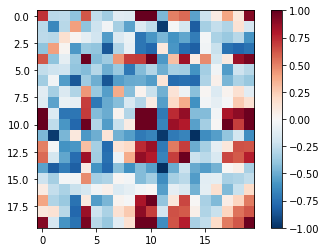

In [141]:
plt.imshow(gamma_ijm[0], cmap="RdBu_r")
plt.colorbar()

In [2]:
def interaction_well_3(r, r_min, r_max, kappa):
    return 0.5 * (np.tanh(kappa * (r + r_min))  + 0.5 * np.tanh(kappa * (r_max - r)))

In [132]:
def interaction_well(r, r_min, r_max, kappa):
    return 0.5 * (np.tanh(kappa * (r - r_min)) * np.tanh(kappa * (r_max - r))) + 0.5

In [153]:
# same as below
def interaction_well(r, r_min, r_max, kappa):
    return 0.25 * (1 + np.tanh(kappa*(r-r_min)))* (1 + np.tanh(kappa*(r_max-r)))

In [18]:
def interaction_well_3(r, r_min, r_max, kappa):
    return 0.5*np.tanh(kappa*(r + r_min))+0.5*np.tanh(kappa*(r_max - r))

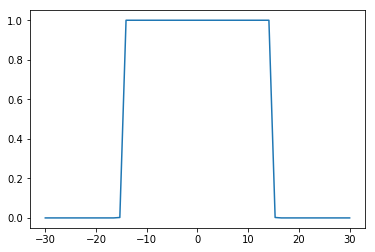

In [19]:
z = np.linspace(-30, 30)
y = interaction_well_3(z, 15, 15, 10)
plt.plot(z,y)

In [22]:
plt.rcParams['figure.facecolor'] = 'w'

In [ ]:
rcParams['figure.facecolor'] = 'w'

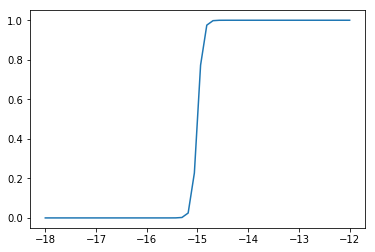

In [23]:
z = np.linspace(-18, -12)
y = interaction_well_3(z, 15, 15, 10)
plt.plot(z,y)

In [16]:
z = np.linspace(-3, 6)
k_m = 2
z_m = 1.5
y = (0.5*np.tanh(k_m*((z-membrane_center)+z_m))+0.5*np.tanh(k_m*(z_m-(z-membrane_center))))

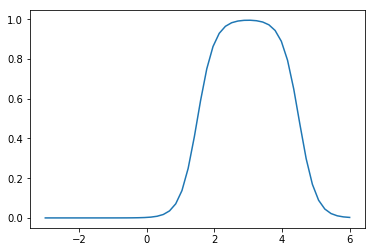

In [17]:
plt.plot(z, y)

In [74]:
def compute_chi(data):
    ca_all = data.query("type == 'CA'")[["x","y","z"]].values
    cb_all = data.query("type == 'CB'")[["x","y","z"]].values
    c_all = data.query("type == 'C'")[["x","y","z"]].values
    n_all = data.query("type == 'N'")[["x","y","z"]].values
    print(len(ca_all), len(cb_all), len(c_all), len(n_all))
    energy = 0 
    for i in range(len(n_all)):
        ca = ca_all[i]
        cb = cb_all[i]
        c = c_all[i]
        n = n_all[i]
        chi0 = -0.83
        k_chi = 20*4.184
        r_ca_cb = cb-ca
        r_c_ca = ca-c
        r_ca_n = n-ca
        norm_r_ca_cb = np.sum(r_ca_cb**2)**0.5
        norm_r_c_ca = np.sum(r_c_ca**2)**0.5
        norm_r_ca_n = np.sum(r_ca_n**2)**0.5
        a = np.cross(-r_c_ca,r_ca_n)/norm_r_c_ca/norm_r_ca_n
        chi = np.dot(a,r_ca_cb)/norm_r_ca_cb
        dchi = chi - chi0
        energy += k_chi*dchi*dchi
    return energy

In [ ]:
input_pdb_filename = "/Users/weilu/Research/server_backup/jan_2019/compute_energy/openmm/12as-openmmawsem.pdb"
data = pd.read_table(input_pdb_filename, sep="\s+", header=None, names=["_","i","type","res","chain","res_id", "x","y","z","_1","_2","_3"])
data = data.dropna().reset_index()
data["res_id"] = data["res_id"].apply(lambda x: int(x))
data["x"] = data["x"].astype(float)

In [76]:
chosen = data.query("res != 'IGL' and res_id != 1 and res_id != 327")
compute_chi(chosen)/4.184

296 296 296 296


84.52557845383485

In [ ]:
def read_beta_parameters():
    ### directly copied from Nick Schafer's
    #os.chdir(parameter_directory)
    in_anti_HB = open("anti_HB", 'r').readlines()
    in_anti_NHB = open("anti_NHB", 'r').readlines()
    in_para_HB = open("para_HB", 'r').readlines()
    in_para_one = open("para_one", 'r').readlines()
    in_anti_one = open("anti_one", 'r').readlines()

    p_par = np.zeros((20))
    p_anti = np.zeros((20))
    p_antihb = np.zeros((20,20,2))
    p_antinhb = np.zeros((20,20,2))
    p_parhb = np.zeros((20,20,2))

    for i in range(20):
        p_par[i] = float(in_para_one[i].strip())
        p_anti[i] = float(in_anti_one[i].strip())
        for j in range(20):
            p_antihb[i][j][0] = float(in_anti_HB[i].strip().split()[j])
            p_antinhb[i][j][0] = float(in_anti_NHB[i].strip().split()[j])
            p_parhb[i][j][0] = float(in_para_HB[i].strip().split()[j])

    for i in range(20):
        for j in range(20):
            p_antihb[i][j][1] = float(in_anti_HB[i+21].strip().split()[j])
            p_antinhb[i][j][1] = float(in_anti_NHB[i+21].strip().split()[j])
            p_parhb[i][j][1] = float(in_para_HB[i+21].strip().split()[j])
    return p_par, p_anti, p_antihb, p_antinhb, p_parhb